In [1]:
# ML용 공통 코드

# 파이썬
# ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os

# 깔끔한 그래프 출력을 위해 %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
# 이미지를 저장할 디렉토리 생성
os.makedirs(IMAGES_PATH, exist_ok=True)

# 이미지 저장
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

from matplotlib import font_manager, rc
import platform

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
    
    
mpl.rcParams['axes.unicode_minus'] = False
# Jupyter Notebook의 출력을 소수점 이하 3자리로 제한
%precision 3

# 그래픽 출력을 좀 더 고급화하기 위한 라이브러리
import seaborn as sns

# 과학 기술 통계 라이브러리
import scipy as sp
from scipy import stats

# 사이킷런 ≥0.20 필수
# 0.20 이상 버전에서 데이터 변환을 위한 Transformer 클래스가 추가됨
import sklearn
assert sklearn.__version__ >= "0.20"

# 노트북 실행 결과를 동일하게 유지하기 위해 시드 고정
# 데이터를 분할할 때 동일한 분할을 만들어 냄
np.random.seed(21)

## 투표 기반 분류기의 성능 확인

In [11]:
# 데이터 생성

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

# 샘플 데이터 생성
X, y = make_moons(n_samples = 500, noise = 0.3, random_state = 21)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 21)

#print(X_train.shape)
#print(X_test.shape)
#print(X_train[0], y_train[0])
# X 는 2개, y 는 1개의 feature 를 가짐

In [12]:
# 성능을 비교할 모델들 import
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import VotingClassifier

# 분류기 생성
log_clf = LogisticRegression(solver = 'lbfgs', random_state = 21)
svm_clf = SVC(random_state = 21, gamma = 'scale')
rnd_clf = RandomForestClassifier(n_estimators = 100, random_state = 21)
# 투표 기반 분류기- 이전에 만들어 높은 분류기들을 사용
# estimators 매개변수에 사용할 분류기를 이름, 분류기 순으로 입력하고 
# voting 매개변수에 hard voting 방식 지정
vot_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('svc', svm_clf), ('rf', rnd_clf)],
    voting = 'hard'
)

In [13]:
# 모델 훈련
# 투표 기반 분류기만 훈련하면 나머지는 알아서 훈련이 됨
# 모두에 대해 훈련을 해서 다수결로 결과를 정함
vot_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=21)),
                             ('svc', SVC(random_state=21)),
                             ('rf', RandomForestClassifier(random_state=21))])

In [14]:
# 각 모델들의 정확도 확인
from sklearn.metrics import accuracy_score

for clf in (log_clf, svm_clf, rnd_clf, vot_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    # 클래스의 이름에서 분류기 이름을 가져옴
    print(clf.__class__.__name__, '의 정확도 : ',
        accuracy_score(y_test, y_pred), sep = '')
    
# 개별 분류기로 가장 높게 나온 분류기보다 투표 기반의 
# VotingClassifier 가 더 정확도가 높음

LogisticRegression의 정확도 : 0.872
SVC의 정확도 : 0.888
RandomForestClassifier의 정확도 : 0.88
VotingClassifier의 정확도 : 0.88


In [15]:
# 간접 투표 방식의  분류기

log_clf = LogisticRegression(solver = 'lbfgs', random_state = 21)
# SVM(SVC)가 확률을 계산할 수 있도록 probability 매개변수 사용
svm_clf = SVC(random_state = 21, gamma = 'scale',
             probability = True)
rnd_clf = RandomForestClassifier(n_estimators = 100, random_state = 21)
# 투표 기반 분류기의 voting 을 soft 로 설정
vot_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('svc', svm_clf), ('rf', rnd_clf)],
    voting = 'soft'
)

for clf in (log_clf, svm_clf, rnd_clf, vot_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test) 
    print(clf.__class__.__name__, '의 정확도 : ',
        accuracy_score(y_test, y_pred), sep = '')

# lr, SVC, rf 의 정확도는 모두 이전과 동일하지만
# VotingClassifier 의 정확도는 더 올라감

LogisticRegression의 정확도 : 0.872
SVC의 정확도 : 0.888
RandomForestClassifier의 정확도 : 0.88
VotingClassifier의 정확도 : 0.872


## Bagging 과 Pasting 을 이용한 앙상블

In [16]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# 사용할 모델, 예측기의 갯수, bootstrap 등을 지정 가능
# 동일한 모델을 가지고 여러 데이터를 학습한 후 합치는 방식
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators = 500,
    max_samples = 100, bootstrap = True,
    random_state = 21
)

bag_clf.fit(X_train, y_train)

y_pred = bag_clf.predict(X_test)
print('정확도 :', accuracy_score(y_test, y_pred)) # 0.872

정확도 : 0.872


In [18]:
# 1개짜리 예측기와 비교 - 1개인 경우보다 여러 예측기를 사용하는게 더 나은 결과

tree_clf = DecisionTreeClassifier(random_state = 21)
tree_clf.fit(X_train, y_train)
pred = tree_clf.predict(X_test)
print('정확도 :', accuracy_score(y_test, y_pred)) # 0.872

정확도 : 0.872


In [19]:
# oob 평가

# oob_score 매개변수를 사용해서 지정 가능
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators = 500,
    max_samples = 100, bootstrap = True,
    random_state = 21, oob_score = True
)

bag_clf.fit(X_train, y_train)

y_pred = bag_clf.predict(X_test)
print('정확도 :', accuracy_score(y_test, y_pred))
print('OOB :', bag_clf.oob_score_) # 0.9144

정확도 : 0.872
OOB : 0.9146666666666666


## Bagging 과 Random Forest

In [21]:
# Bagging - 하나의 알고리즘을 사용
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features = 'sqrt', max_leaf_nodes = 16),
    n_estimators = 500,random_state = 21
)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [24]:
# Random Forest
rnd_clf = RandomForestClassifier(n_estimators = 500, 
                                 max_leaf_nodes = 16, random_state = 21)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

In [25]:
# Bagging 과 Random Forest 비교

print(np.sum(y_pred == y_pred_rf) / len(y_pred))
# 결과는 1.0
# Bagging 과 Random Forest 방식이 예측한 결과가 정확하게 일치함
# Random Forest 는 Bagging 방식의 일부분

1.0


## 타이타닉 데이터에 RandomForest 적용

In [26]:
# 데이터 가져오기

df = sns.load_dataset('titanic')
#df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [27]:
# 결측치 처리

rdf = df.drop(['deck', 'embark_town'], axis = 1)
rdf = rdf.dropna(subset = ['age'], axis = 0, how = 'any') 
most_fre = rdf['embarked'].value_counts(dropna = True).idxmax()
rdf['embarked'].fillna(most_fre, inplace = True)

In [28]:
rdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   survived    714 non-null    int64   
 1   pclass      714 non-null    int64   
 2   sex         714 non-null    object  
 3   age         714 non-null    float64 
 4   sibsp       714 non-null    int64   
 5   parch       714 non-null    int64   
 6   fare        714 non-null    float64 
 7   embarked    714 non-null    object  
 8   class       714 non-null    category
 9   who         714 non-null    object  
 10  adult_male  714 non-null    bool    
 11  alive       714 non-null    object  
 12  alone       714 non-null    bool    
dtypes: bool(2), category(1), float64(2), int64(4), object(4)
memory usage: 63.6+ KB


In [29]:
# 순서가 없는 데이터의 one hot encoding
# 문자열 데이터 없이 모두 숫자형인지 확인 필요

ndf = rdf[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked']]

onehot_sex = pd.get_dummies(ndf['sex'])
ndf = pd.concat([ndf, onehot_sex], axis = 1)

onehot_embarked = pd.get_dummies(ndf['embarked'], prefix = 'town')
ndf = pd.concat([ndf, onehot_embarked], axis = 1)

ndf.drop(['sex', 'embarked'], axis = 1, inplace = True)

In [30]:
ndf.head()

,survived,pclass,age,sibsp,parch,female,male,town_C,town_Q,town_S
0,0,3,22.0,1,0,0,1,0,0,1
1,1,1,38.0,1,0,1,0,1,0,0
2,1,3,26.0,0,0,1,0,0,0,1
3,1,1,35.0,1,0,1,0,0,0,1
4,0,3,35.0,0,0,0,1,0,0,1


In [31]:
# target 과 feature 를 분리
# target 은 정규화를 하지 않으므로 정규화 전에 분리함

# feature
X = ndf[['pclass', 'age', 'sibsp', 'parch', 'female', 
         'male', 'town_C', 'town_Q', 'town_S']]
# target
y = ndf['survived']

In [32]:
# 정규화 - Random Forest 만 수행할거라면 하지 않아도 별 영향 없음
# feature 에 대해 정규화 수행

from sklearn import preprocessing

X = preprocessing.StandardScaler().fit(X).transform(X)

In [34]:
# 훈련 데이터와 테스트 데이터를 분리
# 정규화를 수행한 다음에 데이터 분리

# 생각해볼 점은 데이터가 랜덤인지
# 데이터가 랜덤하게 배치되어 있다면 분할을 할 때 순서대로 
# 일정 부분을 가져와서 사용하면 됨

# 두번째 생각해볼 점은 타겟의 비율
# 타겟의 비율이 고르지 않다면 층화 추출, oversampling, undersamplig 등을 고려
# 이상치 탐지에서 이 부분은 항상 고려 대상 - 타겟이 일정하지 않음

# survived 데이터는 비율이 어느 정도 고른 편이므로 층화 추출을 하지 않아도 괜찮음

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.3,
                                                   random_state = 21)


0    424
1    290
Name: survived, dtype: int64

In [36]:
# 모델을 만들어서 훈련

# 불순도 지표로 entropy 사용, 기본은 gini 계수
# n_estimators 는 트리의 갯수
forest = RandomForestClassifier(criterion = 'entropy', n_estimators = 25,
                               random_state = 21, n_jobs = -1)

forest.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=25, n_jobs=-1,
                       random_state=21)

In [45]:
# 훈련된 모델 테스트 및 평가 지표 확인

from sklearn import metrics

y_pred = forest.predict(X_test)
#print(y_pred[:10])
#print(y_test.values[:10])

tree_matrix = metrics.confusion_matrix(y_test, y_pred)
print(tree_matrix)
# 정확도 계산 - 0.7627, accuracy
print((tree_matrix[0, 0] + tree_matrix[1, 1]) / np.sum(tree_matrix))
tree_report = metrics.classification_report(y_test, y_pred)
print(tree_report)

[[110  26]
 [ 25  54]]
0.7627906976744186
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       136
           1       0.68      0.68      0.68        79

    accuracy                           0.76       215
   macro avg       0.74      0.75      0.75       215
weighted avg       0.76      0.76      0.76       215



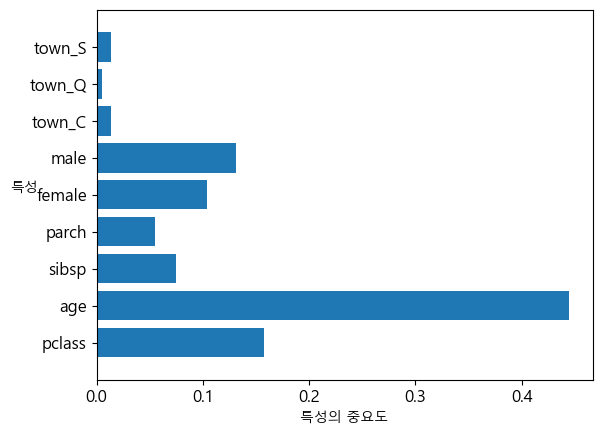

In [48]:
# 특성의 중요도 확인

n_features = X.data.shape[1] # 9

# 그래프를 사용해서 중요도를 시각화
plt.barh(np.arange(n_features), forest.feature_importances_, align = 'center')
plt.yticks(np.arange(n_features),
          ['pclass', 'age', 'sibsp', 'parch', 'female', 
         'male', 'town_C', 'town_Q', 'town_S'])
plt.xlabel('특성의 중요도')
plt.ylabel('특성', rotation = 0)
plt.ylim(-1, n_features)
plt.show()


## Ada Boost

In [53]:
from sklearn.ensemble import AdaBoostClassifier

# 약한 학습기의 갯수, 알고리즘, 학습률 등 지정 가능
# algorithm 은 분류기가 확률을 계산할 수 있으면 SAMME.R 이고
# 계산할 수 없으면 SAMME(default 값)
# 학습률이 너무 크면 최적화가 되지 않을 수 있고
# 너무 작으면 훈련 속도가 느려지면서 overfitting 이 발생할 수 있음
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth = 1),
    n_estimators = 200,
    algorithm = 'SAMME.R',
    learning_rate = 0.5,
    random_state = 21
)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=21)

In [62]:
%%time
# 예측 및 확인

y_pred = ada_clf.predict(X_test)
#print(y_pred[:10])
#print(y_test.values[:10])

tree_matrix = metrics.confusion_matrix(y_test, y_pred)
print(tree_matrix) 
# 이전의 Random Forest 방식에 비해 높은 정확도를 보이고 있음
# 정확도 측정 - 0.8093, accuracy = 0.81
print((tree_matrix[0, 0] + tree_matrix[1, 1]) / np.sum(tree_matrix))
tree_report = metrics.classification_report(y_test, y_pred)
print(tree_report)

[[110  26]
 [ 17  62]]
0.8
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       136
           1       0.70      0.78      0.74        79

    accuracy                           0.80       215
   macro avg       0.79      0.80      0.79       215
weighted avg       0.81      0.80      0.80       215

CPU times: total: 31.2 ms
Wall time: 11.8 ms


## Gradient Boosting

In [60]:
from sklearn.ensemble import GradientBoostingClassifier

# random_state 만 있어도 작동
# 각 결정 트리가 독립적인게 아니라 앞이 끝나야 뒤의 트리가
# 동작할 수 있기 때문에 n_jobs 를 사용할 수 없음
# 그래서 일반적으로 시간이 오래 걸림
grd_clf = GradientBoostingClassifier(
    random_state = 21
)

grd_clf.fit(X_train, y_train)

y_pred = grd_clf.predict(X_test)

tree_matrix = metrics.confusion_matrix(y_test, y_pred)
print(tree_matrix) 
# 정확도 - 0.80
print((tree_matrix[0, 0] + tree_matrix[1, 1]) / np.sum(tree_matrix))
tree_report = metrics.classification_report(y_test, y_pred)
print(tree_report)

# Ada Boosting 과 비슷한 정확도를 보임

[[115  21]
 [ 22  57]]
0.8
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       136
           1       0.73      0.72      0.73        79

    accuracy                           0.80       215
   macro avg       0.79      0.78      0.78       215
weighted avg       0.80      0.80      0.80       215



In [69]:
%%time
# 하이퍼 파라미터 튜닝
# 시간이 많을 때는 여러 값을 설정

from sklearn.model_selection import GridSearchCV

# 파라미터의 조합은 총 6가지
params = {
    'n_estimators' : [100, 200, 500],
    'learning_rate' : [0.05, 0.1]
}

gridcv = GridSearchCV(grd_clf, param_grid = params,
                     cv = 3, verbose = 1)
gridcv.fit(X_train, y_train)

print('최적의 파라미터 :', gridcv.best_params_)
print('최고의 정확도 :', gridcv.best_score_)
# 최적 파라미터 : 0.05 & 100
# 정확도는 0.8137
# 0.8 이 가장 높은 정확도였던 이전 보다 높은 정확도를 보임

Fitting 3 folds for each of 6 candidates, totalling 18 fits
최적의 파라미터 : {'learning_rate': 0.05, 'n_estimators': 100}
최고의 정확도 : 0.8137339778274776
CPU times: total: 4.41 s
Wall time: 4.42 s


In [70]:
# 파라미터 튜닝의 결과를 사용해서 예측

gd_pred = gridcv.best_estimator_.predict(X_test)
gd_accuracy = accuracy_score(y_test, gd_pred)
print(gd_accuracy)

0.7953488372093023
